In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hashlib

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax

def short_hash(s: str) -> str:
    """Generate a 7-character hash from a given string."""
    return hashlib.sha256(s.encode()).hexdigest()[:7]

fsize = 15
plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [55]:
from taln.taln_aln import (
    norm_text,
    tokenize,
    align_ng, 
    align_lcs,
    align_difflib,
    reconstruct_target_by_token,
)

In [56]:
cols = ["title", "question", "question_id", "is_impossible", "answer_type"]

In [57]:
# post shift (consistent with subword tokenization)
tdf = pd.read_json("data/shift_train.lst.json", orient="records").drop(columns=cols)
tdf["hash_source"] = tdf["source"].apply(short_hash)
tdf["hash_target"] = tdf["target"].apply(short_hash)

wdf = pd.read_json("data/clean_train.lst.json", orient="records").drop(columns=cols)
wdf["hash_source"] = tdf["hash_source"]
wdf["hash_target"] = tdf["hash_target"]

tdf = tdf[tdf["target"].str.split().str.len() > 2]

tdf_idx = tdf.set_index(["hash_source", "hash_target"]).index
tdf = tdf.groupby(["source", "target"])["idx_start"].apply(set).reset_index()

wdf = wdf.set_index(["hash_source", "hash_target"]).loc[tdf_idx].reset_index()[["source", "target", "idx_start"]]
wdf = wdf.groupby(["source", "target"])["idx_start"].apply(set).reset_index()

In [58]:
tdf.head()

,source,target,idx_start
0,"\n Australia: The event was held in Canberra, ...",Australian Federal Police.,{561}
1,"\n Australia: The event was held in Canberra, ...",Australian and Chinese officials,{697}
2,"\n Australia: The event was held in Canberra, ...",a message stick,{361}
3,"\n China: In China, the torch was first welcom...",the French flag,{1098}
4,"\n China: In China, the torch was first welcom...",the LVMH Group,{416}


In [59]:
wdf.head()

,source,target,idx_start
0,"\n Australia: The event was held in Canberra, ...",Australian Federal Police.,{562}
1,"\n Australia: The event was held in Canberra, ...",Australian and Chinese officials,{698}
2,"\n Australia: The event was held in Canberra, ...",a message stick,{362}
3,"\n China: In China, the torch was first welcom...",the French flag,{1099}
4,"\n China: In China, the torch was first welcom...",the LVMH Group,{417}


In [60]:
import time
# Apply function with timing
def timed_align(x, fn, ttype): # fn takes in source and target
    start_time = time.time()
    ctx = x["source"]
    tgt = x["target"]

    if ttype == 'whitespace':
        tgt = tgt.strip()

    result = fn(ctx, tgt, ttype)
    end_time = time.time()

    # Calculate elapsed time in milliseconds
    t = (end_time - start_time) * 1000
    return result, t

def align_naive(ctx, tgt, ttype):
    if tgt in ctx:
        idx = ctx.index(tgt)
        found = {
            "token": tgt,
            "enc_token": -1, 
            "start_idx": ctx.index(tgt),
            "end_idx": idx + len(tgt),
        }
        return [[found]]
    else:
        return [[]]

methods = {
    "custom": align_ng,
    "lcs": align_lcs,
    "difflib": align_difflib,
    "naive": align_naive,
}

In [61]:
for m in methods:
    # alignments and time
    tdf[[f"{m}_aln", f"{m}_time_ms"]] = tdf.apply(
        timed_align, axis=1, result_type="expand", args=(methods[m],"token")
    )

    # num alignments
    tdf[f"{m}_len"] = tdf[f"{m}_aln"].apply(len)

    tdf[f"{m}_idx_start"] = tdf[f"{m}_aln"].apply(lambda x: set([i[0].get("start_idx", -1) for i in x]) if len(x)>0 and len(x[0])>0 else {-1})

    tdf[f"{m}_text"] = tdf[f"{m}_aln"].apply(lambda x: reconstruct_target_by_token("", x[0] if len(x)>0 else ""))
    tdf[f"{m}_same"] = tdf["target"] == tdf[f"{m}_text"]


In [62]:
for m in methods:
    # alignments and time
    wdf[[f"{m}_aln", f"{m}_time_ms"]] = wdf.apply(
        timed_align, axis=1, result_type="expand", args=(methods[m], "whitespace")
    )

    # num alignments
    wdf[f"{m}_len"] = wdf[f"{m}_aln"].apply(len)

    wdf[f"{m}_idx_start"] = wdf[f"{m}_aln"].apply(lambda x: set([i[0].get("start_idx", -1) for i in x]) if len(x)>0 and len(x[0])>0 else {-1})

    wdf[f"{m}_text"] = wdf[f"{m}_aln"].apply(lambda x: reconstruct_target_by_token("", x[0] if len(x)>0 else "", " "))
    wdf[f"{m}_same"] = wdf["target"].str.strip() == wdf[f"{m}_text"].str.strip()

In [63]:
# compare to the start
def compute_set_operations(x, real_idx="idx_start", pred_idx="custom_idx_start", vals=False):
    set1 = x[real_idx]
    set2 = x[pred_idx]

    left_diff = set1 - set2  # Elements in set1 but not in set2
    intersection = set1 & set2  # Common elements
    right_diff = set2 - set1  # Elements in set2 but not in set1

    if vals:
        return pd.Series([left_diff, intersection, right_diff])
    else:
        return pd.Series([len(left_diff), len(intersection), len(right_diff)])

# token ops
for m in list(methods.keys()):

    tdf[[f"{m}_lv", f"{m}_xv", f"{m}_rv"]] = tdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start", vals=True), axis=1)
    tdf[[f"{m}_l", f"{m}_x", f"{m}_r"]] = tdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start"), axis=1)
    tdf[f"{m}_found"] = tdf.apply(
        lambda x: x[f"{m}_l"] == 0, axis=1
    )

# whitespace ops
for m in list(methods.keys()):

    wdf[[f"{m}_lv", f"{m}_xv", f"{m}_rv"]] = wdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start", vals=True), axis=1)
    wdf[[f"{m}_l", f"{m}_x", f"{m}_r"]] = wdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start"), axis=1)
    wdf[f"{m}_found"] = wdf.apply(
        lambda x: x[f"{m}_l"] == 0, axis=1
    )
    

In [64]:
# custom
print(tdf["custom_same"].sum()/tdf.shape[0]*100)
print(tdf["lcs_same"].sum()/tdf.shape[0]*100)
print(tdf["difflib_same"].sum()/tdf.shape[0]*100)
print(tdf["naive_same"].sum()/tdf.shape[0]*100)

95.70035661084277
95.72292691734754
95.72066988669707
100.0


In [65]:
# custom
print(wdf["custom_same"].sum()/wdf.shape[0]*100)
print(wdf["lcs_same"].sum()/wdf.shape[0]*100)
print(wdf["difflib_same"].sum()/wdf.shape[0]*100)
print(wdf["naive_same"].sum()/wdf.shape[0]*100)

50.46946237529906
50.48751862050287
50.39046630253239
100.0


In [14]:
both = tdf.query("custom_found & naive_found").shape[0]
neither = tdf.query("~custom_found & ~naive_found").shape[0]
found_only = tdf.query("custom_found & ~naive_found").shape[0]
naive_only = tdf.query("~custom_found & naive_found").shape[0]

In [15]:
# Create the original DataFrame
tbl = pd.DataFrame(
    [[both, found_only],
     [naive_only, neither]],
    index=["custom_found True", "custom_found False"],
    columns=["naive_found True", "naive_found False"]
)

# Add row sums
tbl["Total"] = tbl.sum(axis=1)

# Add column sums
tbl.loc["Total"] = tbl.sum(axis=0)
tbl


,naive_found True,naive_found False,Total
custom_found True,66321,0,66321
custom_found False,3454,0,3454
Total,69775,0,69775


In [16]:
# Create the original DataFrame
tbl = pd.DataFrame(
    [[both, found_only],
     [naive_only, neither]],
    index=["custom_found True", "custom_found False"],
    columns=["naive_found True", "naive_found False"]
)

# Add row sums
tbl["Total"] = tbl.sum(axis=1)

# Add column sums
tbl.loc["Total"] = tbl.sum(axis=0)
tbl / tbl.loc["Total", "Total"] * 100

,naive_found True,naive_found False,Total
custom_found True,95.049803,0.0,95.049803
custom_found False,4.950197,0.0,4.950197
Total,100.000000,0.0,100.000000


In [19]:
# plt.scatter(np.arange(10, 100), power_law(np.arange(10, 100), 0.003, 1.5, 0.011), label="Power Law", color="blue")
# plt.xscale("log")
# plt.yscale("log")

In [20]:
times = tdf.assign(ntks_src=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
   .groupby("ntks_src")[[
       "custom_time_ms",
       "lcs_time_ms",
       "difflib_time_ms",
       "naive_time_ms",
       ]].mean()

In [21]:
def plaw_fit(x, y):
    logx = np.log10(x)
    logy = np.log10(y)
    ceoffs = np.polyfit(logx, logy, 1)
    b, loga = ceoffs
    a = 10**loga

    x_fit = np.logspace(np.log10(min(x)), np.log10(max(x)), 1000)
    y_fit = a * x_fit**b
    return (x_fit, y_fit, a, b)

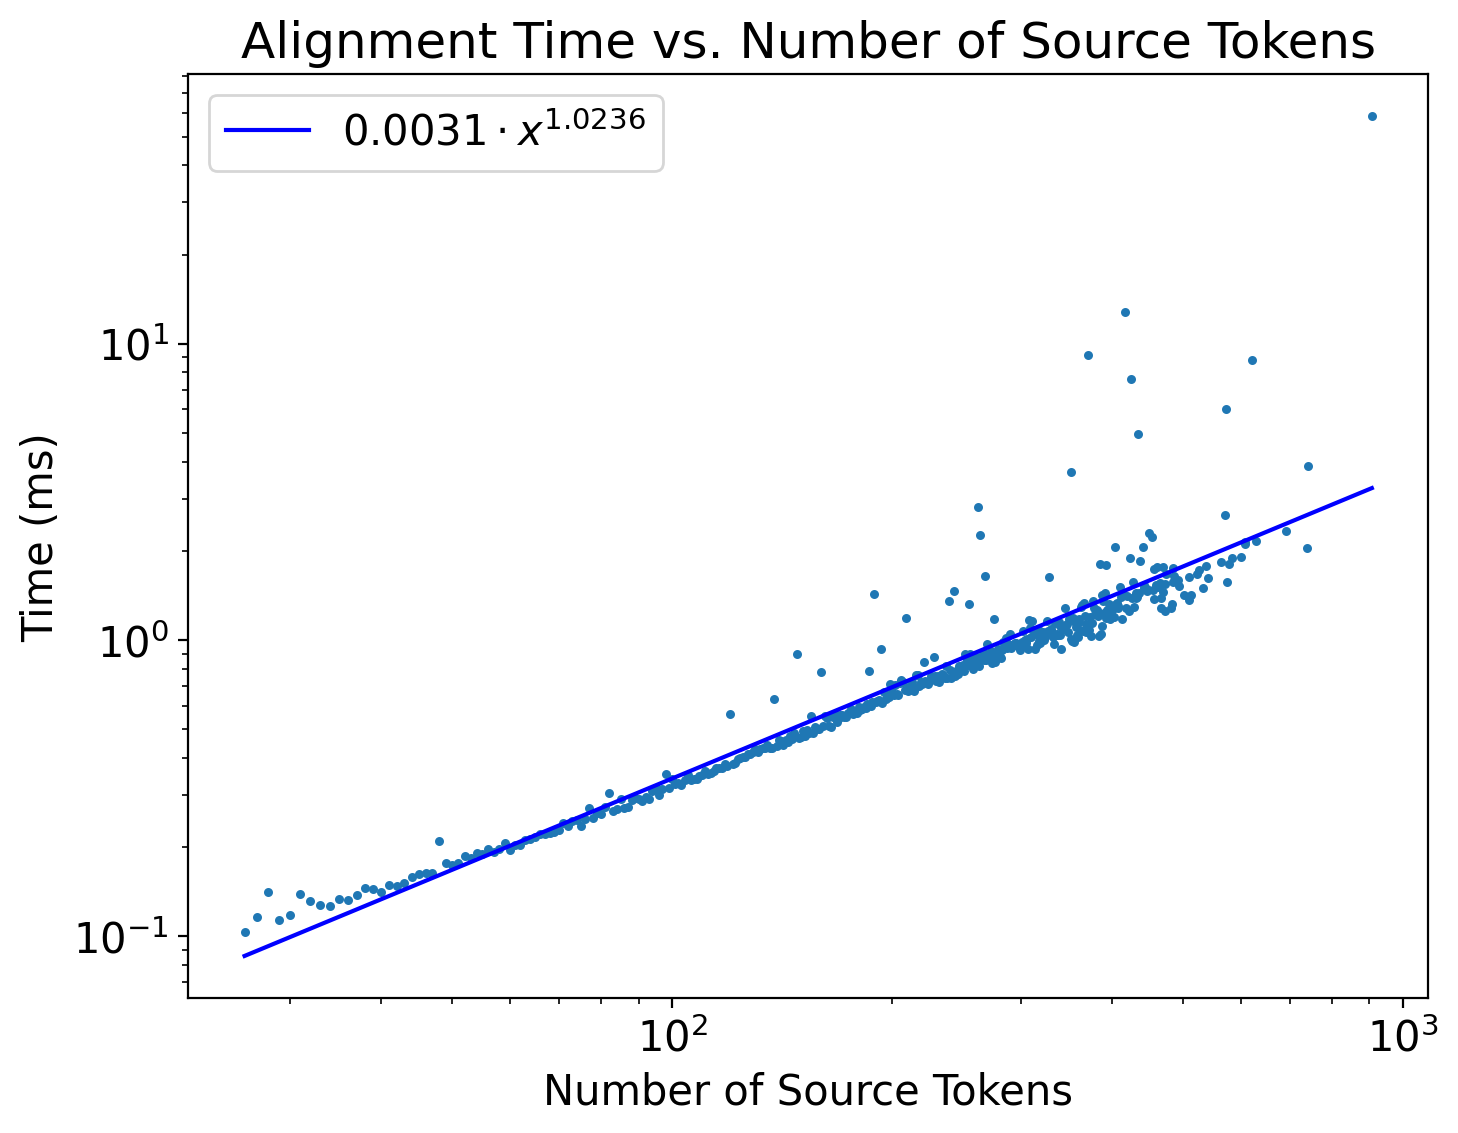

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

x = times.index.values
y = times["custom_time_ms"].values
ax.scatter(x,y,s=5)

x_fit, y_fit, a, b = plaw_fit(x, y)
ax.plot(x_fit, y_fit, color="blue", label=fr"${a:,.4f} \cdot x^{{{b:,.4f}}}$")

ax.set(**{
    "xlabel": "Number of Source Tokens",
    "ylabel": "Time (ms)",
    "title": "Alignment Time vs. Number of Source Tokens",
    "xscale": "log",
    "yscale": "log",
})
ax.legend()
plt.show()

In [23]:
LABELS = {
    "custom_time_ms": "Custom",
    "lcs_time_ms": "LCS",
    "difflib_time_ms": "Difflib",
    "naive_time_ms": "Naive"
}

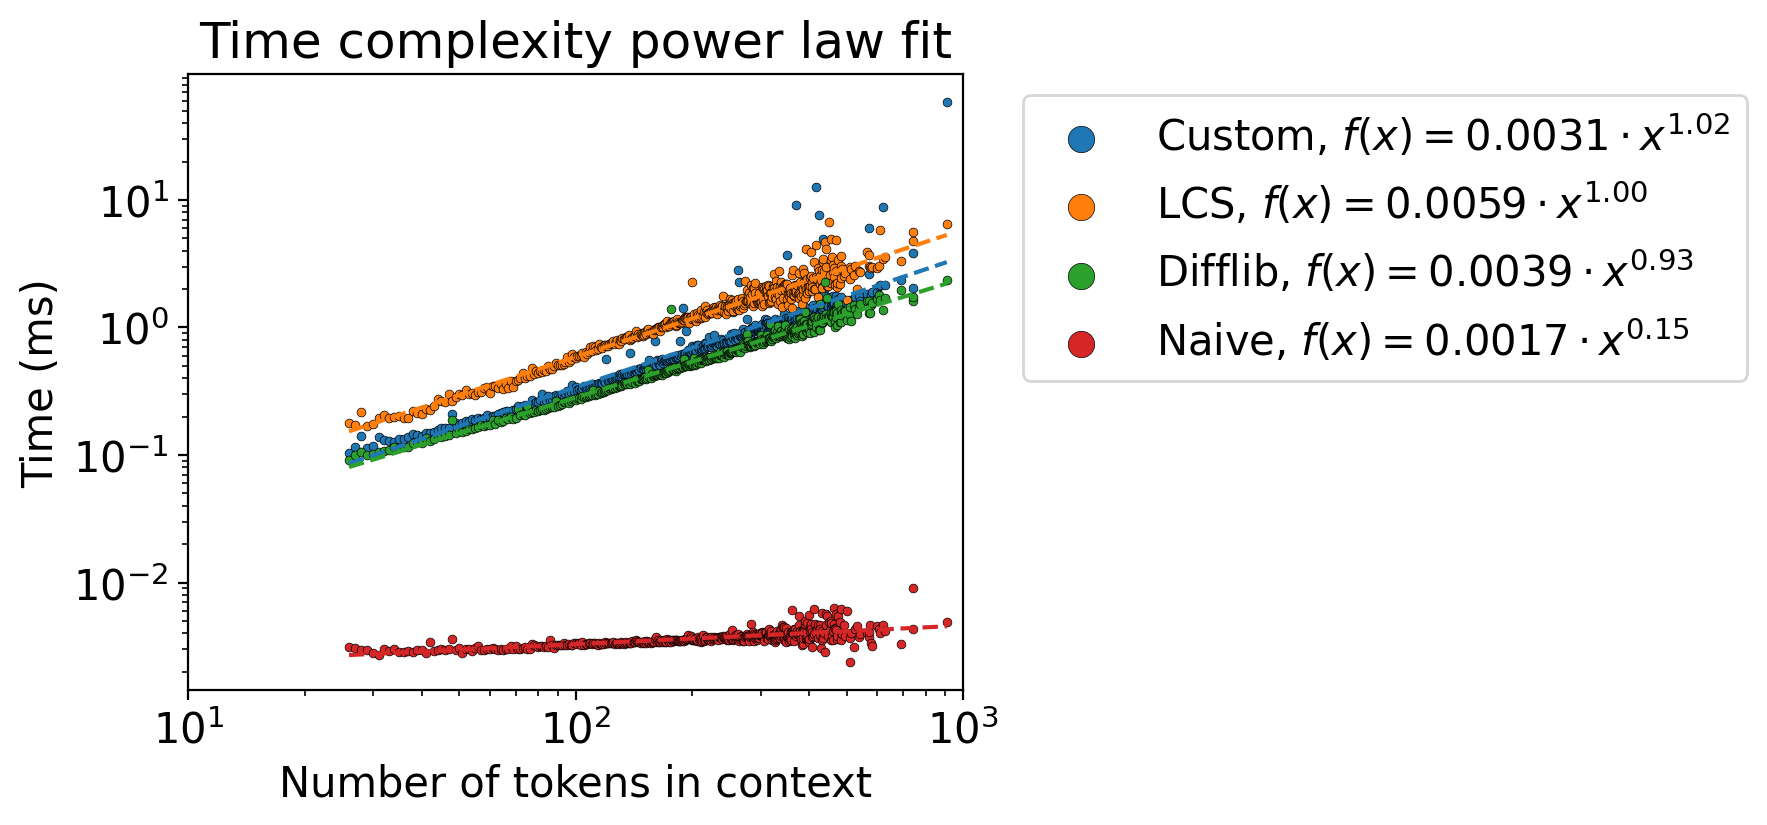

In [24]:
fig, ax = plt.subplots(figsize=(5,4))


x = times.index.values
for k, v in LABELS.items():
    y = times[k].values

    # fit to all the data points
    x_fit, y_fit, a, b = plaw_fit(x, y)

    ax.plot(x_fit, y_fit, linestyle="--", markeredgecolor="black", markeredgewidth=0.2)

    label = fr"{v}, $f(x) = {a:.4f} \cdot x^{{{b:.2f}}}$"

    # plot the curve fit
    ax.scatter(x, y, s=10, label=label, edgecolors="black", linewidth=0.25)

# Customize axes and labels
ax.set(**{
    "ylabel": "Time (ms)",
    "xlabel": "Number of tokens in context",
    "xscale": "log",
    "yscale": "log",
    "xlim": (10, 1e3),
    "title": "Time complexity power law fit",
})
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3)
plt.show()

In [25]:
tacc = tdf.assign(ntks_ctx=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
    .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]] \
    .agg(lambda x: x.sum() / x.count() * 100)

wacc = wdf.assign(ntks_ctx=wdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
    .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]] \
    .agg(lambda x: x.sum() / x.count() * 100)

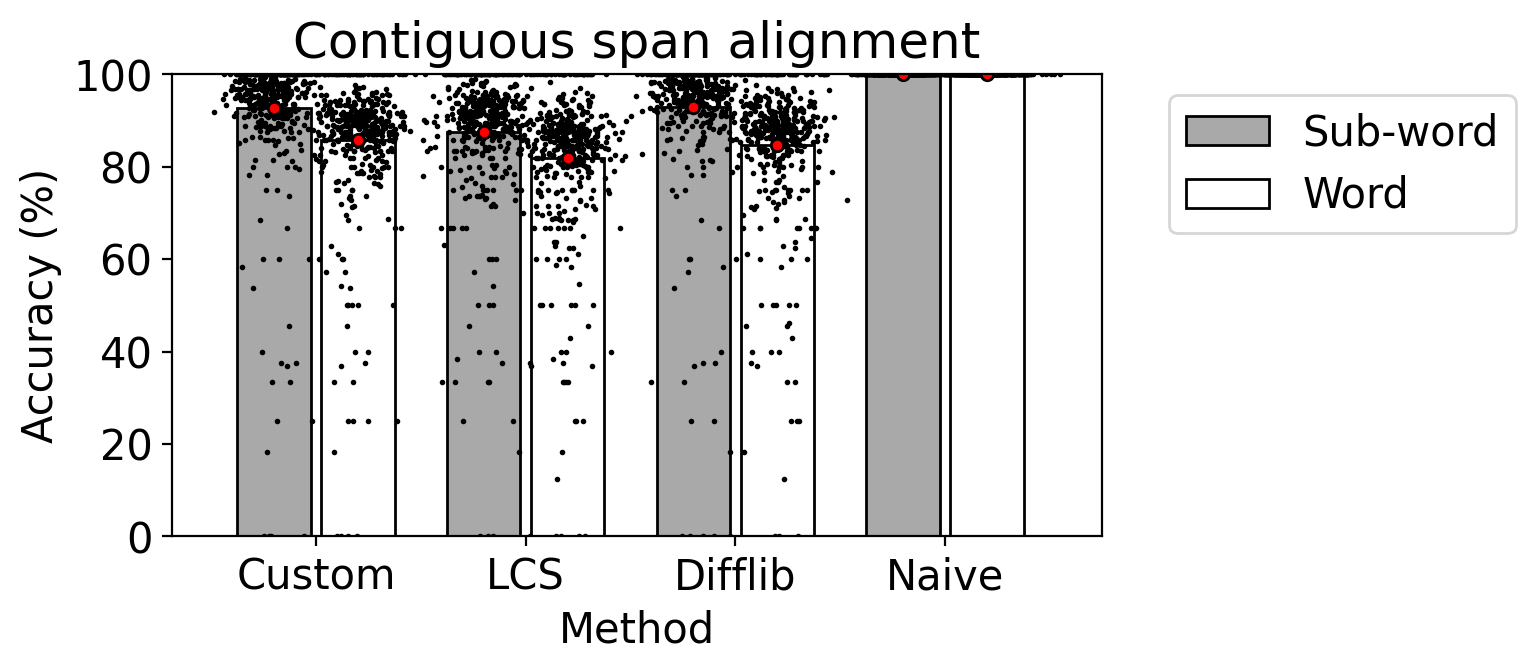

In [26]:
fig, ax = plt.subplots(figsize=(6,3))

x = np.arange(4)
width = 0.35  # Narrower bars for side-by-side
gap = 0.025

# First bar set (tacc)
for idx, (i, y) in enumerate(tacc.items()):
    x_vals = np.random.normal(idx - (width/2 + gap), 0.1, size=len(y))
    ax.scatter(x_vals, y.values, s=1, alpha=1, color="k")
    ax.bar(idx - (width/2 + gap), y.mean(), width, zorder=-1,
           edgecolor="black", facecolor="darkgrey")
    ax.scatter(idx - (width/2 + gap), y.mean(), s=20, zorder=1,
           edgecolor="black", facecolor="red")

# Second bar set (wacc)
for idx, (i, y) in enumerate(wacc.items()):
    x_vals = np.random.normal(idx + (width/2 + gap), 0.1, size=len(y))
    ax.scatter(x_vals, y.values, s=1, alpha=1, color="k")
    ax.bar(idx + (width/2 + gap), y.mean(), width, zorder=-1,
           edgecolor="black", facecolor="white")
    ax.scatter(idx + (width/2 + gap), y.mean(), s=20, zorder=1,
           edgecolor="black", facecolor="red")

ax.set(**{
    "ylabel": "Accuracy (%)",
    "xlabel": "Method",
    "xticks": np.arange(4),
    "xticklabels": ["Custom", "LCS", "Difflib", "Naive"],
    "ylim": (0, 100),
})

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="darkgrey", edgecolor="black", label="Sub-word"),
    Patch(facecolor="white", edgecolor="black", label="Word"),
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), markerscale=3)
ax.set_title("Contiguous span alignment")
plt.show()

In [27]:
tacc.mean(), wacc.mean()

(custom_found      92.697795
 lcs_found         87.466187
 difflib_found     92.989197
 naive_found      100.000000
 dtype: float64,
 custom_found      85.759809
 lcs_found         81.962713
 difflib_found     84.716278
 naive_found      100.000000
 dtype: float64)

In [28]:
def compute_coverage(aln_list, nutks_ans):
    if len(aln_list) > 0:
        return len(set(i["enc_token"] for i in aln_list[0])) / nutks_ans
    return 0

In [29]:
# df["custom_coverage"] = df["custom_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_ans"]
# df["lcs_coverage"] = df["lcs_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_ans"]
# df["difflib_coverage"] = df["difflib_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_ans"]

cov = tdf.assign(
    nutks_ans=lambda d: d["target"].apply(lambda x: len(tokenize(x)[0])),
    custom_coverage=lambda d: d.apply(lambda row: compute_coverage(row["custom_aln"], row["nutks_ans"]), axis=1),
    lcs_coverage=lambda d: d.apply(lambda row: compute_coverage(row["lcs_aln"], row["nutks_ans"]), axis=1),
    difflib_coverage=lambda d: d.apply(lambda row: compute_coverage(row["difflib_aln"], row["nutks_ans"]), axis=1),
)

In [33]:
cov_mean = cov[["nutks_ans", "custom_coverage", "lcs_coverage", "difflib_coverage"]].assign(naive_coverage=1).groupby("nutks_ans").mean()

In [31]:
# cov = tdf.assign(ntks_ctx=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
#     .groupby("ntks_ctx")[["custom_coverage", "lcs_coverage", "difflib_coverage", "naive_coverage"]] \
#     .agg(lambda x: x.sum() / x.count() * 100)

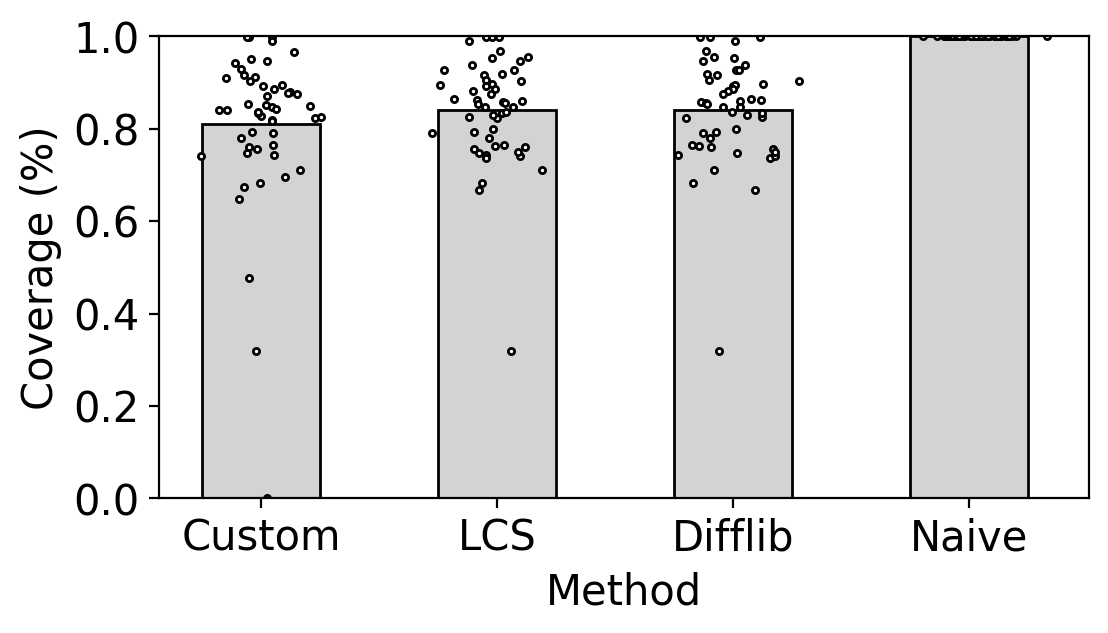

In [38]:
fig, ax = plt.subplots(figsize=(6,3))

x = np.arange(4)
width = 0.5

for idx, (i, y) in enumerate(cov_mean.items()):
    x = np.random.normal(idx, 0.1, size=len(y))
    ax.scatter(x, y.values, s=5, edgecolors="black", facecolors="white")
    ax.bar(idx, y.mean(), width, label=y.name, zorder=-1, edgecolor="black", facecolor="lightgrey")


ax.set(**{
    "ylabel": "Coverage (% tokens aligned)",
    "xlabel": "Method",
    "xticks": np.arange(4),
    "xticklabels": ["Custom", "LCS", "Difflib", "Naive"],
    "ylim": (0, 1),
})
plt.show()

In [43]:
LABELS = {'custom_coverage': 'Custom',
          'lcs_coverage': 'LCS',
          'difflib_coverage': 'Difflib',
          'naive_coverage': 'Naive'
          }

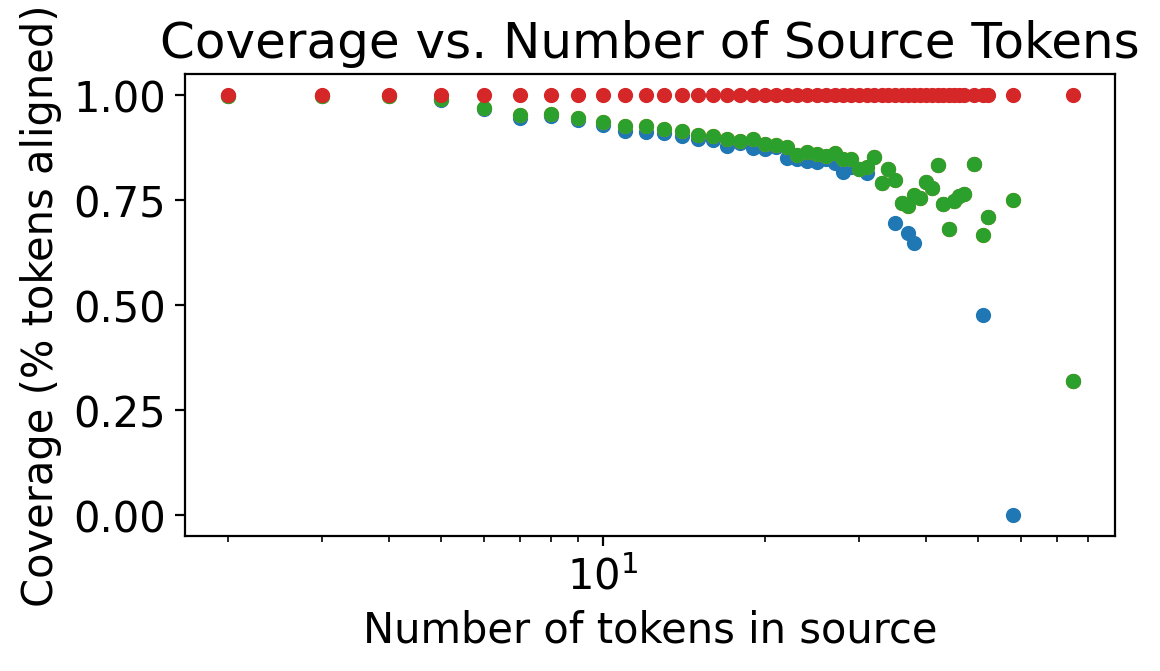

In [52]:
fig, ax = plt.subplots(figsize=(6, 3))

x = cov_mean.index.values
for k, v in LABELS.items():
    y = cov_mean[k].values

    # plot the curve fit
    ax.scatter(x, y,  label=label, s=20)

ax.set(**{
    "ylabel": "Coverage (% tokens aligned)",
    "xlabel": "Number of tokens in source",
    "xscale": "log",
    # "yscale": "log",
    # "xlim": (10, 1e3),
    "title": "Coverage vs. Number of Source Tokens",
})
plt.show()

In [165]:
(tdf["custom_found"]).sum()/tdf.shape[0]*100

np.float64(95.04980293801505)

In [53]:
# custom
print(tdf["custom_same"].sum()/tdf.shape[0]*100)
print(tdf["lcs_same"].sum()/tdf.shape[0]*100)
print(tdf["difflib_same"].sum()/tdf.shape[0]*100)
print(tdf["naive_same"].sum()/tdf.shape[0]*100)

96.09888928699391
96.12325331422429
96.12038695807954
100.0


In [203]:
print((tdf["custom_text"] == tdf["target"]).sum()/tdf.shape[0]*100)
print((tdf["lcs_text"] == tdf["target"]).sum()/tdf.shape[0]*100)
print((tdf["difflib_text"] == tdf["target"]).sum()/tdf.shape[0]*100)

96.09888928699391
96.12325331422429
96.12038695807954


In [202]:
print((wdf["target"].str.strip() == wdf["custom_text"]).sum()/wdf.shape[0]*100)
print((wdf["target"].str.strip() == wdf["lcs_text"]).sum()/wdf.shape[0]*100)
print((wdf["target"].str.strip() == wdf["difflib_text"]).sum()/wdf.shape[0]*100)

54.184163382300255
54.19706198495163
53.843067001074886


In [204]:
src = "Single-cell rnaseq identified Sox2-positive neural progenitor cells."
tgt = " Sox2 progenitor cells."

In [205]:
align_ng(src, tgt, ttype="token")

[[{'token': ' Sox', 'enc_token': 39645, 'start_idx': 29, 'end_idx': 33},
  {'token': '2', 'enc_token': 17, 'start_idx': 33, 'end_idx': 34},
  {'token': ' progen', 'enc_token': 84360, 'start_idx': 50, 'end_idx': 57},
  {'token': 'itor', 'enc_token': 1960, 'start_idx': 57, 'end_idx': 61},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 61, 'end_idx': 67},
  {'token': '.', 'enc_token': 13, 'start_idx': 67, 'end_idx': 68}]]

In [206]:
align_ng(src, tgt, ttype="whitespace")

[[{'token': 'progenitor',
   'enc_token': 'progenitor',
   'start_idx': 51,
   'end_idx': 61},
  {'token': 'cells.', 'enc_token': 'cells.', 'start_idx': 62, 'end_idx': 68}]]

In [207]:
align_lcs(src, tgt)

[[{'token': ' Sox', 'enc_token': 39645, 'start_idx': 29, 'end_idx': 33},
  {'token': '2', 'enc_token': 17, 'start_idx': 33, 'end_idx': 34},
  {'token': ' progen', 'enc_token': 84360, 'start_idx': 50, 'end_idx': 57},
  {'token': 'itor', 'enc_token': 1960, 'start_idx': 57, 'end_idx': 61},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 61, 'end_idx': 67},
  {'token': '.', 'enc_token': 13, 'start_idx': 67, 'end_idx': 68}]]

In [208]:
align_lcs(src, tgt, ttype="whitespace")

[[{'token': 'progenitor',
   'enc_token': 'progenitor',
   'start_idx': 51,
   'end_idx': 61},
  {'token': 'cells.', 'enc_token': 'cells.', 'start_idx': 62, 'end_idx': 68}]]

In [209]:
align_difflib(src, tgt)

[[{'token': ' Sox', 'enc_token': 39645, 'start_idx': 29, 'end_idx': 33},
  {'token': '2', 'enc_token': 17, 'start_idx': 33, 'end_idx': 34},
  {'token': ' progen', 'enc_token': 84360, 'start_idx': 50, 'end_idx': 57},
  {'token': 'itor', 'enc_token': 1960, 'start_idx': 57, 'end_idx': 61},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 61, 'end_idx': 67},
  {'token': '.', 'enc_token': 13, 'start_idx': 67, 'end_idx': 68}]]

In [210]:
align_difflib(src, tgt, ttype="whitespace")

[[{'token': 'progenitor',
   'enc_token': 'progenitor',
   'start_idx': 51,
   'end_idx': 61},
  {'token': 'cells.', 'enc_token': 'cells.', 'start_idx': 62, 'end_idx': 68}]]

In [214]:
tdf.query("~custom_found & ~naive_found")

,source,target,idx_start,custom_aln,custom_time_ms,custom_len,custom_start_idx,custom_text,custom_same,lcs_aln,...,difflib_x,difflib_r,difflib_found,naive_lv,naive_xv,naive_rv,naive_l,naive_x,naive_r,naive_found


In [215]:
# Goal:
# 	•	Show that enumerating all alignments (instead of greedy/LCS) captures alignments missed by traditional greedy subsequence methods.

# How to Generate:
# 	•	Take well-known alignment methods as baselines:
# 	•	LCS-based alignments (difflib)
# 	•	Greedy token-matching methods (your original greedy code)
# 	•	Define a metric: “Coverage” = (# unique aligned tokens) / (# tokens in target).
# 	•	Run experiments on a labeled dataset (e.g., SQuAD QA answers mapped to context).
# 	•	Report the percentage of missed alignments by baseline methods vs. your tool.

# Visualization:
# 	•	Bar Plot: “Coverage” comparison across methods (Greedy, LCS, Your Tool).